In [ ]:
library("tidyverse")
library("readr")
library("dplyr")
library("stringr")
library("ggplot2")
library("psych")
library("knitr")
library("nortest")
library("car")
library("zoo")

In [24]:
cpu_data <- read.csv("Dataset/Intel_CPUs.csv", header = TRUE,
                     stringsAsFactors = FALSE, na.strings = c("", "N/A"))
head(cpu_data)

,Product_Collection,Vertical_Segment,Processor_Number,Status,Launch_Date,Lithography,Recommended_Customer_Price,nb_of_Cores,nb_of_Threads,Processor_Base_Frequency,⋯,T,Intel_Hyper_Threading_Technology_,Intel_Virtualization_Technology_VTx_,Intel_64_,Instruction_Set,Instruction_Set_Extensions,Idle_States,Thermal_Monitoring_Technologies,Secure_Key,Execute_Disable_Bit
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,7th Generation Intel® Core™ i7 Processors,Mobile,i7-7Y75,Launched,Q3'16,14 nm,$393.00,2,4,1.30 GHz,⋯,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
2,8th Generation Intel® Core™ i5 Processors,Mobile,i5-8250U,Launched,Q3'17,14 nm,$297.00,4,8,1.60 GHz,⋯,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
3,8th Generation Intel® Core™ i7 Processors,Mobile,i7-8550U,Launched,Q3'17,14 nm,$409.00,4,8,1.80 GHz,⋯,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
4,Intel® Core™ X-series Processors,Desktop,i7-3820,End of Life,Q1'12,32 nm,$305.00,4,8,3.60 GHz,⋯,66.8°C,Yes,Yes,Yes,64-bit,"SSE4.2, AVX, AES",Yes,Yes,NA,Yes
5,7th Generation Intel® Core™ i5 Processors,Mobile,i5-7Y57,Launched,Q1'17,14 nm,$281.00,2,4,1.20 GHz,⋯,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
6,Intel® Celeron® Processor 3000 Series,Mobile,3205U,Launched,Q1'15,14 nm,$107.00,2,2,1.50 GHz,⋯,105°C,No,Yes,Yes,64-bit,SSE4.1/4.2,Yes,Yes,Yes,Yes


In [26]:
cpu_data <- cpu_data %>% select("Vertical_Segment", "Lithography",
                                "Recommended_Customer_Price", "nb_of_Cores", "nb_of_Threads",
                                "Processor_Base_Frequency", "Cache", "Max_Memory_Size",
                                "Max_Memory_Bandwidth", "Execute_Disable_Bit"
)

In [27]:
recommend_price_cleaning <- function(price_range) {
  if (grepl("-", price_range)) {
    range <- strsplit(price_range, "-")[[1]]
    return((as.double(range[1]) + as.double(range[2])) / 2)
  }
  return(price_range)
}

cpu_data$Recommended_Customer_Price <- gsub("\\$", "", cpu_data$Recommended_Customer_Price) 
cpu_data$Recommended_Customer_Price <- gsub(",", "", cpu_data$Recommended_Customer_Price)

cpu_data$Recommended_Customer_Price <- sapply(cpu_data$Recommended_Customer_Price, recommend_price_cleaning) 
cpu_data$Recommended_Customer_Price <- as.double(cpu_data$Recommended_Customer_Price) 

# Lithography converting.
cpu_data <- cpu_data %>%
  mutate(Lithography = gsub("nm|\\s", "", Lithography),
         Lithography = as.double(Lithography))

## Remove any missing data in Recommended_Customer_Price
cpu_data <- cpu_data[!is.na(cpu_data$Recommended_Customer_Price), ]

print(apply(is.na(cpu_data), 2, sum))

          Vertical_Segment                Lithography 
                         0                         10 
Recommended_Customer_Price                nb_of_Cores 
                         0                          0 
             nb_of_Threads   Processor_Base_Frequency 
                       138                          1 
                     Cache            Max_Memory_Size 
                         2                        158 
      Max_Memory_Bandwidth        Execute_Disable_Bit 
                       384                         56 


## Phân tích phương sai với Vertical_Segment

In [28]:
df2 <- data.frame(
   Recommend_Customer_Price=cpu_data$Recommended_Customer_Price,
   Vertical_Segment=cpu_data$Vertical_Segment
)

In [29]:
df2$Vertical_Segment <- as.factor(df2$Vertical_Segment)
df2 %>% select(Vertical_Segment) %>% table()

Vertical_Segment
 Desktop Embedded   Mobile   Server 
     324      166      305      506 

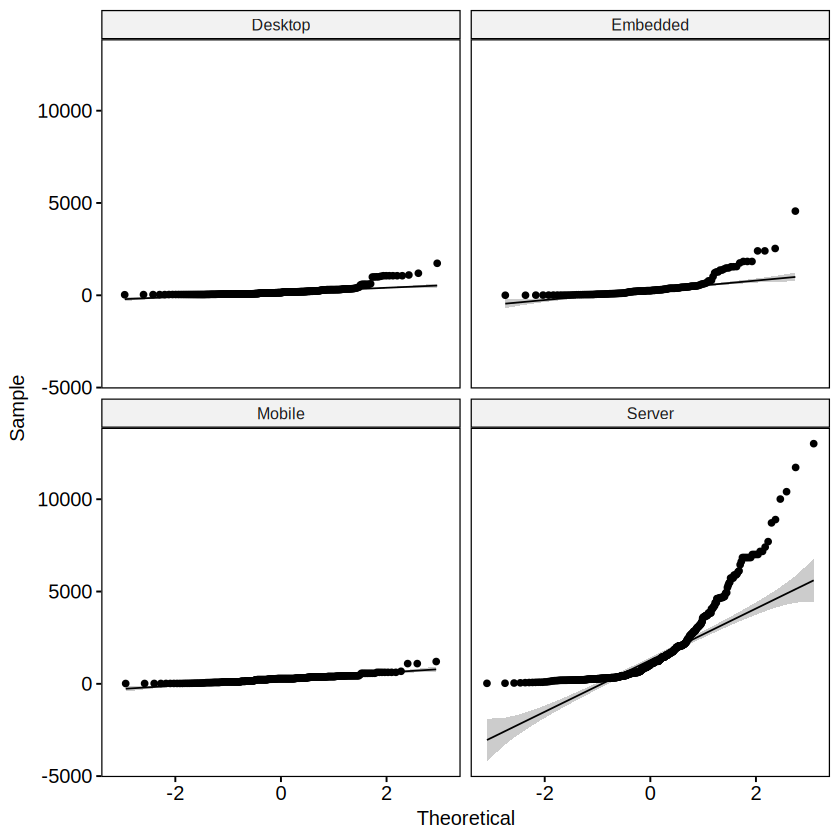

In [30]:
# Check normal distribution of each factor
library(ggpubr)
ggqqplot(df2, "Recommend_Customer_Price", facet.by = "Vertical_Segment")

In [31]:
# Using Shapiro-Test
library(rstatix)
df2 %>% group_by(Vertical_Segment) %>% shapiro_test(Recommend_Customer_Price)

Vertical_Segment,variable,statistic,p
<fct>,<chr>,<dbl>,<dbl>
Desktop,Recommend_Customer_Price,0.6372197,1.190630e-25
Embedded,Recommend_Customer_Price,0.6343410,1.102538e-18
Mobile,Recommend_Customer_Price,0.8988342,2.119081e-13
Server,Recommend_Customer_Price,0.7682101,4.163691e-26


Từ kết quả này chúng ta có thể thấy các nhóm đang không tuân theo phân phối chuẩn

In [32]:
df2_log <- df2
df2_log$Recommend_Customer_Price <- log(df2_log$Recommend_Customer_Price)

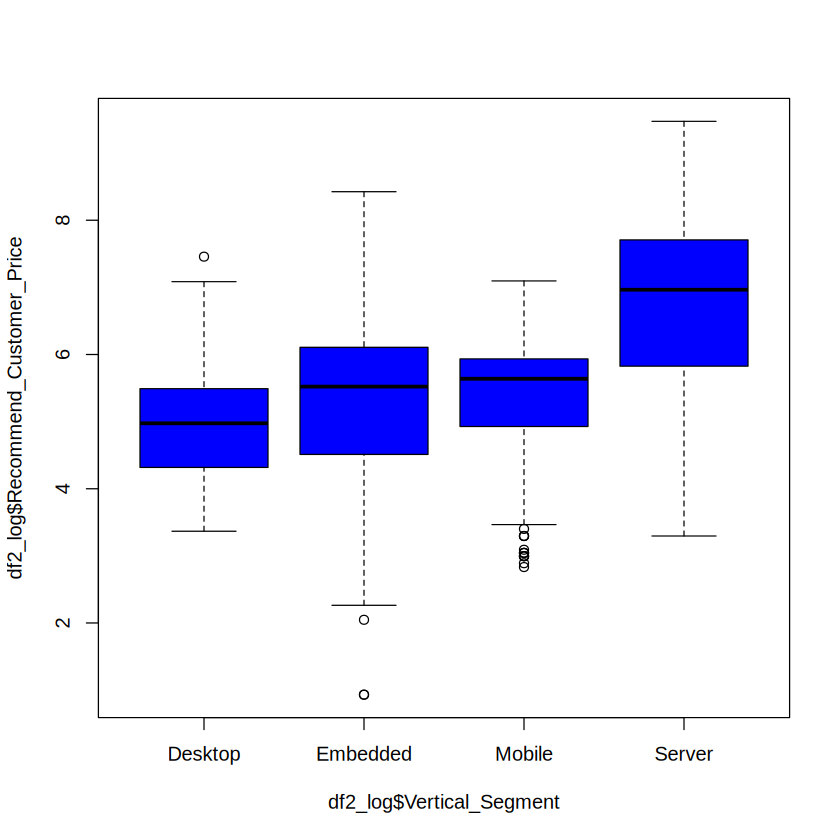

In [35]:
boxplot(df2_log$Recommend_Customer_Price ~ df2_log$Vertical_Segment, col="blue")

Chúng ta sử dụng Log Transformation để đưa dữ liệu về phân phối chuẩn

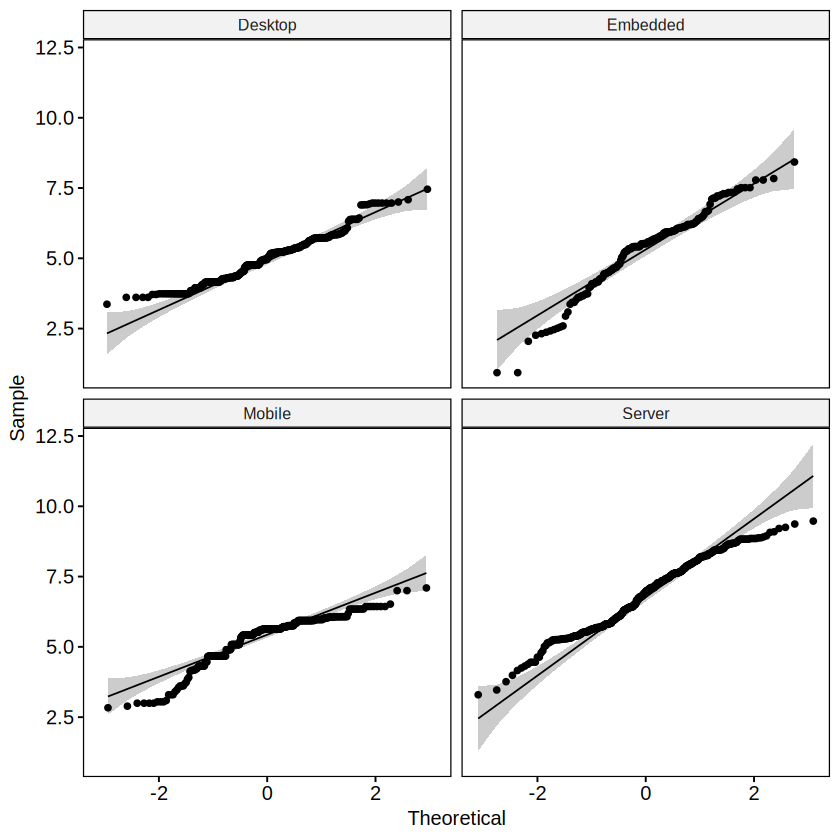

In [33]:
ggqqplot(df2_log, "Recommend_Customer_Price", facet.by = "Vertical_Segment")

In [34]:
df2_log %>% group_by(Vertical_Segment) %>% shapiro_test(Recommend_Customer_Price)

Vertical_Segment,variable,statistic,p
<fct>,<chr>,<dbl>,<dbl>
Desktop,Recommend_Customer_Price,0.9691617,2.151445e-06
Embedded,Recommend_Customer_Price,0.9622703,1.784832e-04
Mobile,Recommend_Customer_Price,0.8862699,2.681886e-14
Server,Recommend_Customer_Price,0.9805617,2.784525e-06


In [75]:
av1 <- aov(df2_log$Recommend_Customer_Price ~ df2_log$Vertical_Segment)
summary(av1)

                           Df Sum Sq Mean Sq F value Pr(>F)    
df2_log$Vertical_Segment    3  874.5  291.50   270.1 <2e-16 ***
Residuals                1297 1399.8    1.08                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Phân tích phương sai với Lithography

In [45]:
df_1 <- data.frame(
   Recommend_Customer_Price=cpu_data$Recommended_Customer_Price,
   Lithography=cpu_data$Lithography
)

In [46]:
df_1 <- df_1[!is.na(df_1$Lithography), ]
df_1 %>% select(Lithography) %>% is.na() %>% sum

[1] 0

In [47]:
df_1$Lithography <- as.factor(df_1$Lithography)
df_1 %>% select(Lithography) %>% table()

Lithography
 14  22  32  45  65  90 130 
407 481 211 140  27  15  10 

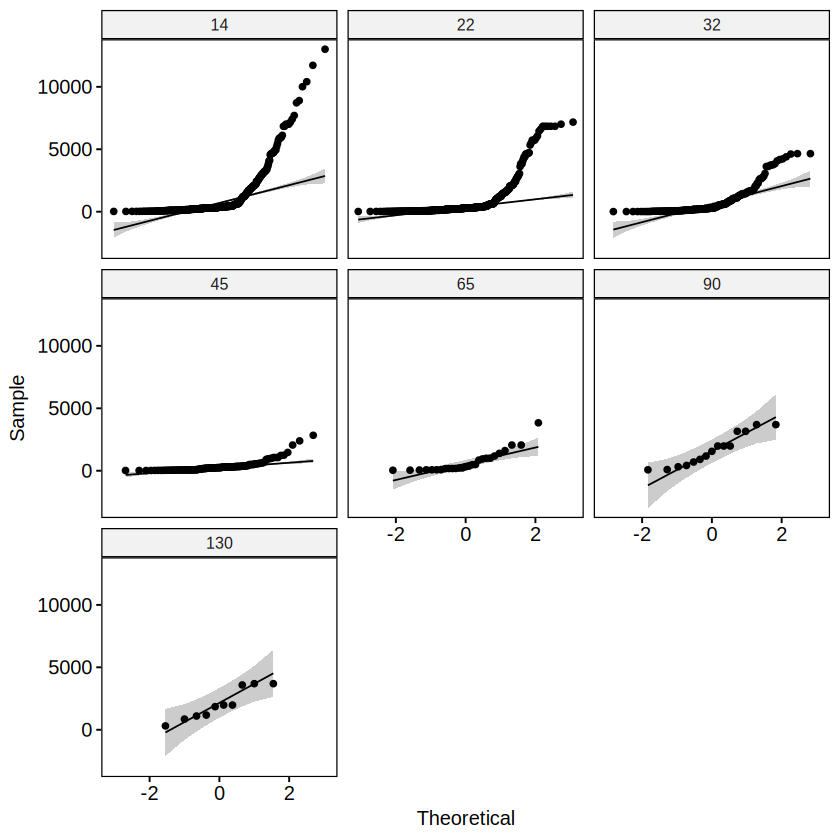

In [48]:
ggqqplot(df_1, "Recommend_Customer_Price", facet.by = "Lithography")

In [49]:
df_1 %>% group_by(Lithography) %>% shapiro_test(Recommend_Customer_Price)

Lithography,variable,statistic,p
<fct>,<chr>,<dbl>,<dbl>
14,Recommend_Customer_Price,0.5806998,3.909581e-30
22,Recommend_Customer_Price,0.5340664,1.024863e-33
32,Recommend_Customer_Price,0.7106769,7.232454e-19
45,Recommend_Customer_Price,0.6478197,7.663535e-17
65,Recommend_Customer_Price,0.7503609,2.116581e-05
90,Recommend_Customer_Price,0.9077229,1.249496e-01
130,Recommend_Customer_Price,0.8856940,1.515816e-01


In [59]:
df_1_log <- df_1
df_1_log$Recommend_Customer_Price <- log(df_1_log$Recommend_Customer_Price)

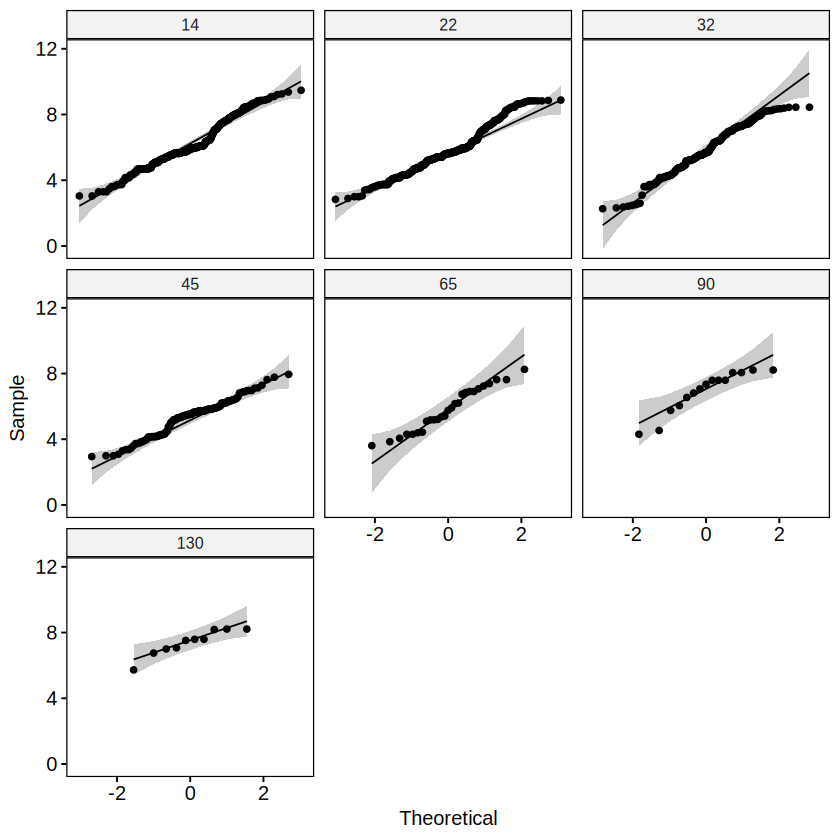

In [60]:
ggqqplot(df_1_log, "Recommend_Customer_Price", facet.by = "Lithography")

In [62]:
df_1_log %>% group_by(Lithography) %>% shapiro_test(Recommend_Customer_Price)

Lithography,variable,statistic,p
<fct>,<chr>,<dbl>,<dbl>
14,Recommend_Customer_Price,0.9625633,1.121499e-08
22,Recommend_Customer_Price,0.9654768,3.304262e-09
32,Recommend_Customer_Price,0.9796265,3.765724e-03
45,Recommend_Customer_Price,0.9699437,3.522309e-03
65,Recommend_Customer_Price,0.9562612,3.027658e-01
90,Recommend_Customer_Price,0.8740464,3.870526e-02
130,Recommend_Customer_Price,0.9002176,2.203045e-01


In [63]:
Recommend_Customer_Price_Log <- df_1_log$Recommend_Customer_Price
Lithography <- df_1_log$Lithography

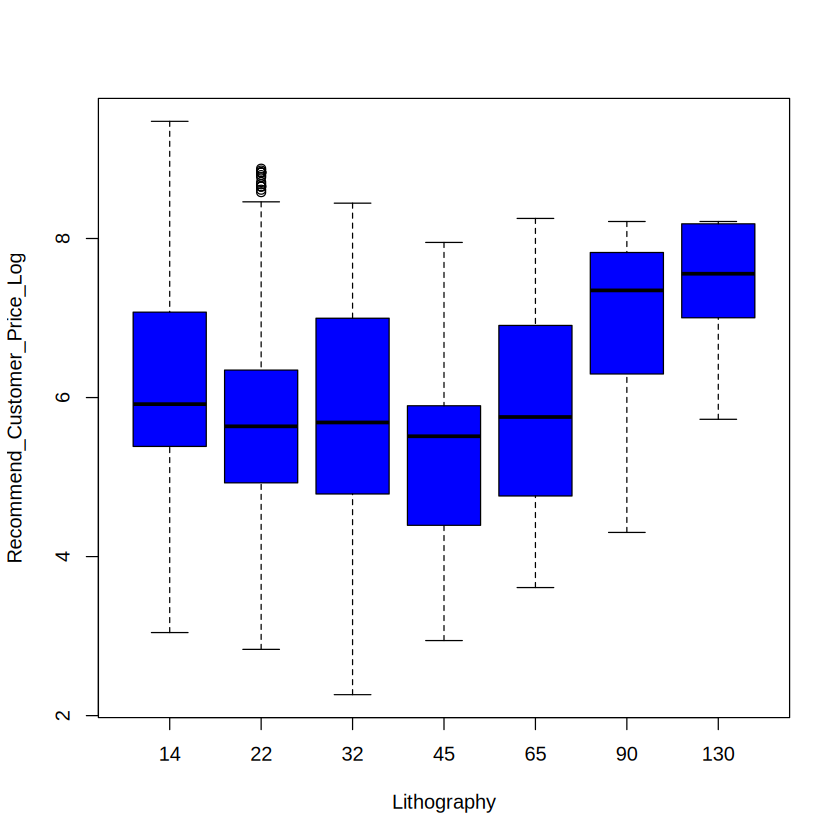

In [72]:
boxplot(Recommend_Customer_Price_Log ~ Lithography, col="blue")

# Xây dựng mô hình

In [65]:
av <- aov(Recommend_Customer_Price_Log ~ Lithography)
summary(av)

              Df Sum Sq Mean Sq F value   Pr(>F)    
Lithography    6  114.4  19.066   11.74 7.64e-13 ***
Residuals   1284 2085.4   1.624                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### Phân tích hậu định

In [67]:
tk <- TukeyHSD(av)
tk

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Recommend_Customer_Price_Log ~ Lithography)

$Lithography
               diff         lwr          upr     p adj
22-14  -0.387636364 -0.64110129 -0.134171442 0.0001395
32-14  -0.318239062 -0.63749349  0.001015365 0.0513599
45-14  -0.788568380 -1.15730270 -0.419834058 0.0000000
65-14  -0.315928455 -1.06383426  0.431977346 0.8753154
90-14   0.782948098 -0.20650341  1.772399607 0.2272769
130-14  1.254544878  0.04991967  2.459170085 0.0348924
32-22   0.069397302 -0.24135933  0.380153934 0.9946533
45-22  -0.400932016 -0.76233386 -0.039530169 0.0185919
65-22   0.071707909 -0.67261016  0.816025974 0.9999569
90-22   1.170584462  0.18384205  2.157326872 0.0086049
130-22  1.642181242  0.43978023  2.844582250 0.0011399
45-32  -0.470329318 -0.88056123 -0.060097410 0.0129168
65-32   0.002310607 -0.76690218  0.771523390 1.0000000
90-32   1.101187160  0.09553339  2.106840931 0.0213286
130-32  1.572783940  0

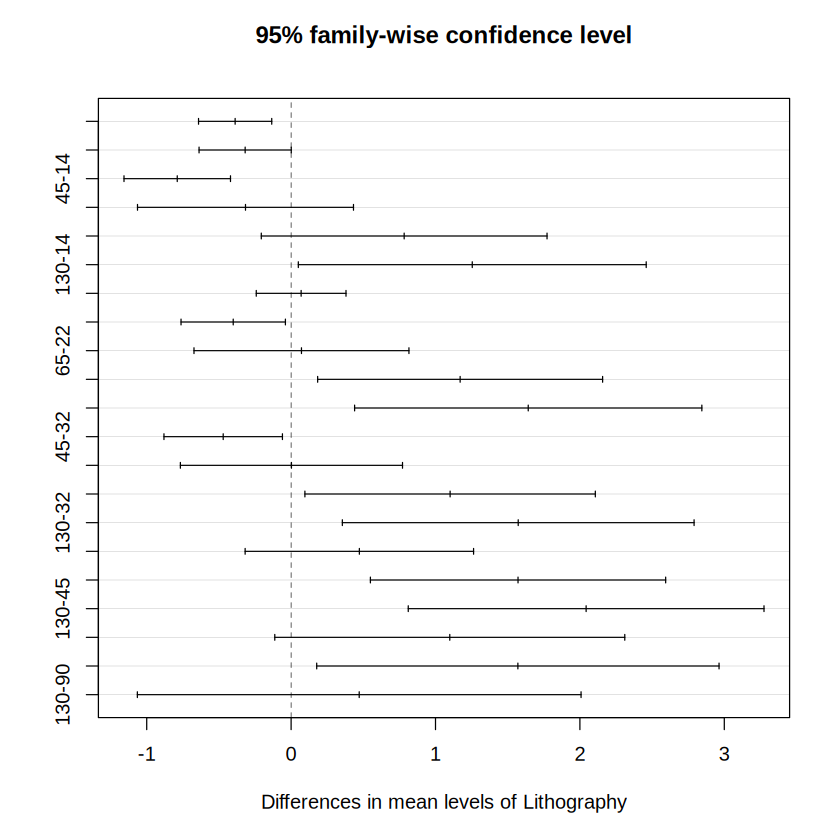

In [69]:
plot(tk)

Sử dụng phương pháp TurkeyHSD, ta thấy được các chỉ số của từng cặp nhóm:
- `diff`: Hiệu số / Sự khác biệt giữa hai nhóm.
- `lwr/upr`: `lower`-`upper` -- Khoảng tin cậy 95%
   - Nếu 2 chỉ số này đều > 0 hoặc < 0 ==> Có sự khác biệt giữa 2 nhóm.
	- Có thể kết luận 2 nhóm này có sự khác biệt nhau
- `p adj`: `p-value` sau khi hiệu chỉnh.

In [71]:
pairwise.t.test(Recommend_Customer_Price_Log, Lithography, p.adjust="bonferroni", pool.sd = T)


	Pairwise comparisons using t tests with pooled SD 

data:  Recommend_Customer_Price_Log and Lithography 

    14      22      32      45      65      90     
22  0.00014 -       -       -       -       -      
32  0.06935 1.00000 -       -       -       -      
45  7.8e-09 0.02270 0.01536 -       -       -      
65  1.00000 1.00000 1.00000 1.00000 -       -      
90  0.41176 0.00999 0.02633 0.00013 0.15773 -      
130 0.04508 0.00122 0.00302 2.3e-05 0.01883 1.00000

P value adjustment method: bonferroni 